# Breast Cancer

In [8]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_accuracy
import tensorflow as tf 
from tensorflow.keras.applications import MobileNetV2

In [2]:

root_folder = "D:\Deep Learning\cancer"

# Dictionary to store images for each category
image_data = {'benign': [], 'malignant': [], 'normal': []}

for category in image_data.keys():
    category_folder = os.path.join(root_folder, category)
    for filename in os.listdir(category_folder):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            # Construct the full file path
            img_path = os.path.join(category_folder, filename)
            # Read the image file
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (128, 128))
                image_data[category].append(img_resized)
                if len(image_data[category]) == 3:
                    break 

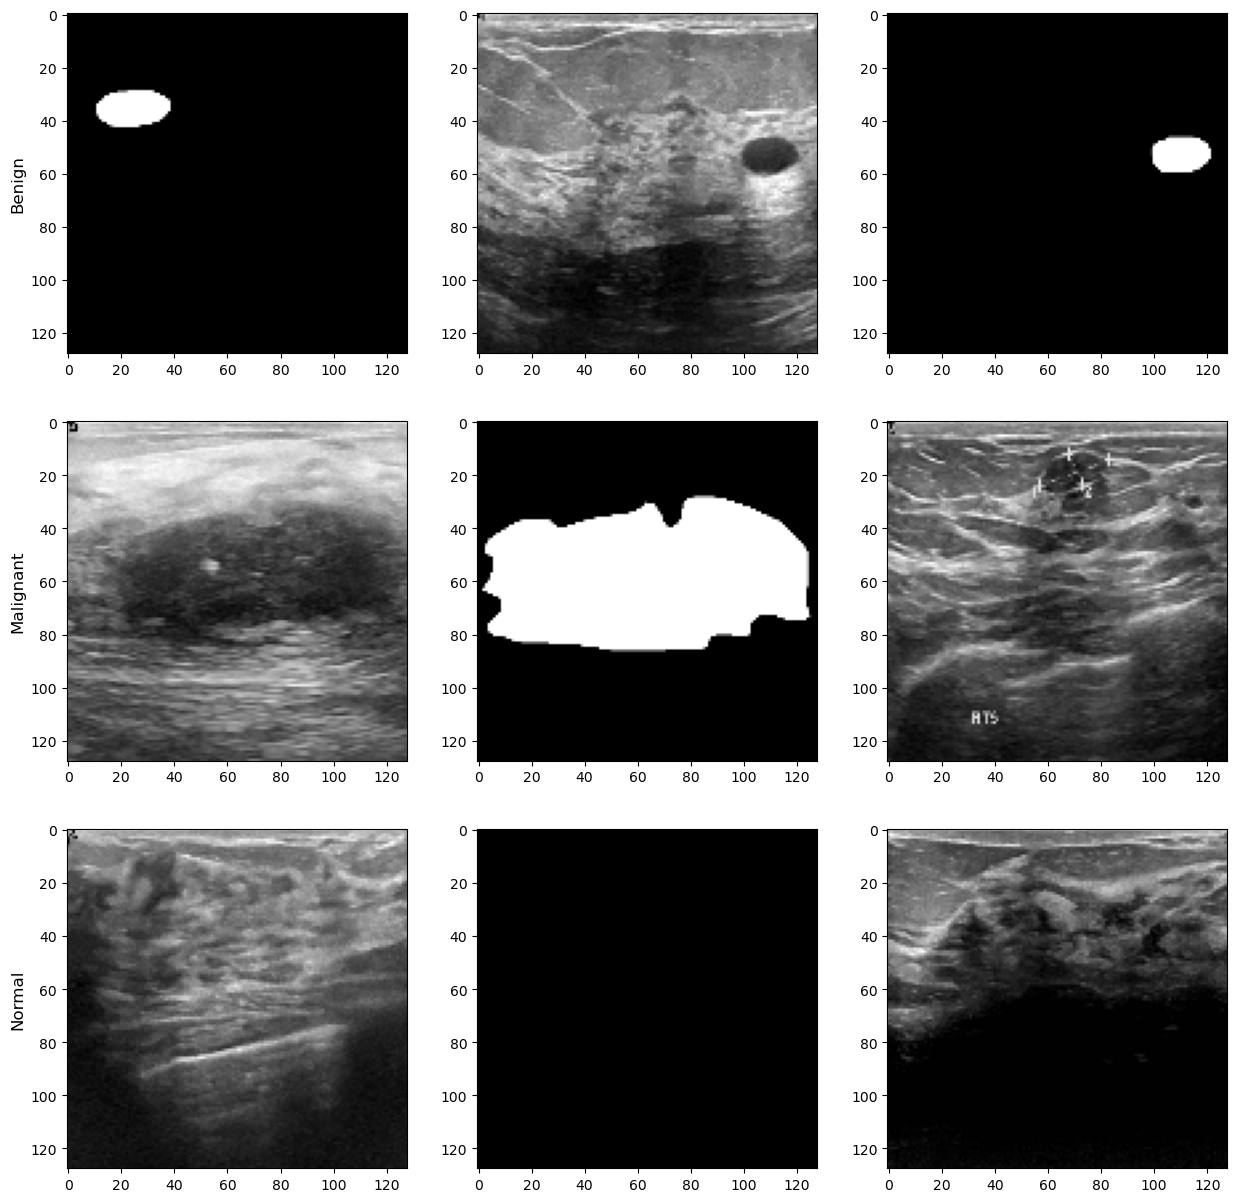

In [3]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

for i, (category, images) in enumerate(image_data.items()):
    for j, img in enumerate(images):
        axes[i, j].imshow(img)
        if j == 0:
            axes[i, j].set_ylabel(category.capitalize(), size='large')
        axes[i, j].axis('on')

plt.show()

Training set class distribution: (array(['benign', 'malignant', 'normal'], dtype='<U9'), array([35, 35, 35], dtype=int64))
Validation set class distribution: (array(['benign', 'malignant', 'normal'], dtype='<U9'), array([10, 10, 10], dtype=int64))
Test set class distribution: (array(['benign', 'malignant', 'normal'], dtype='<U9'), array([5, 5, 5], dtype=int64))


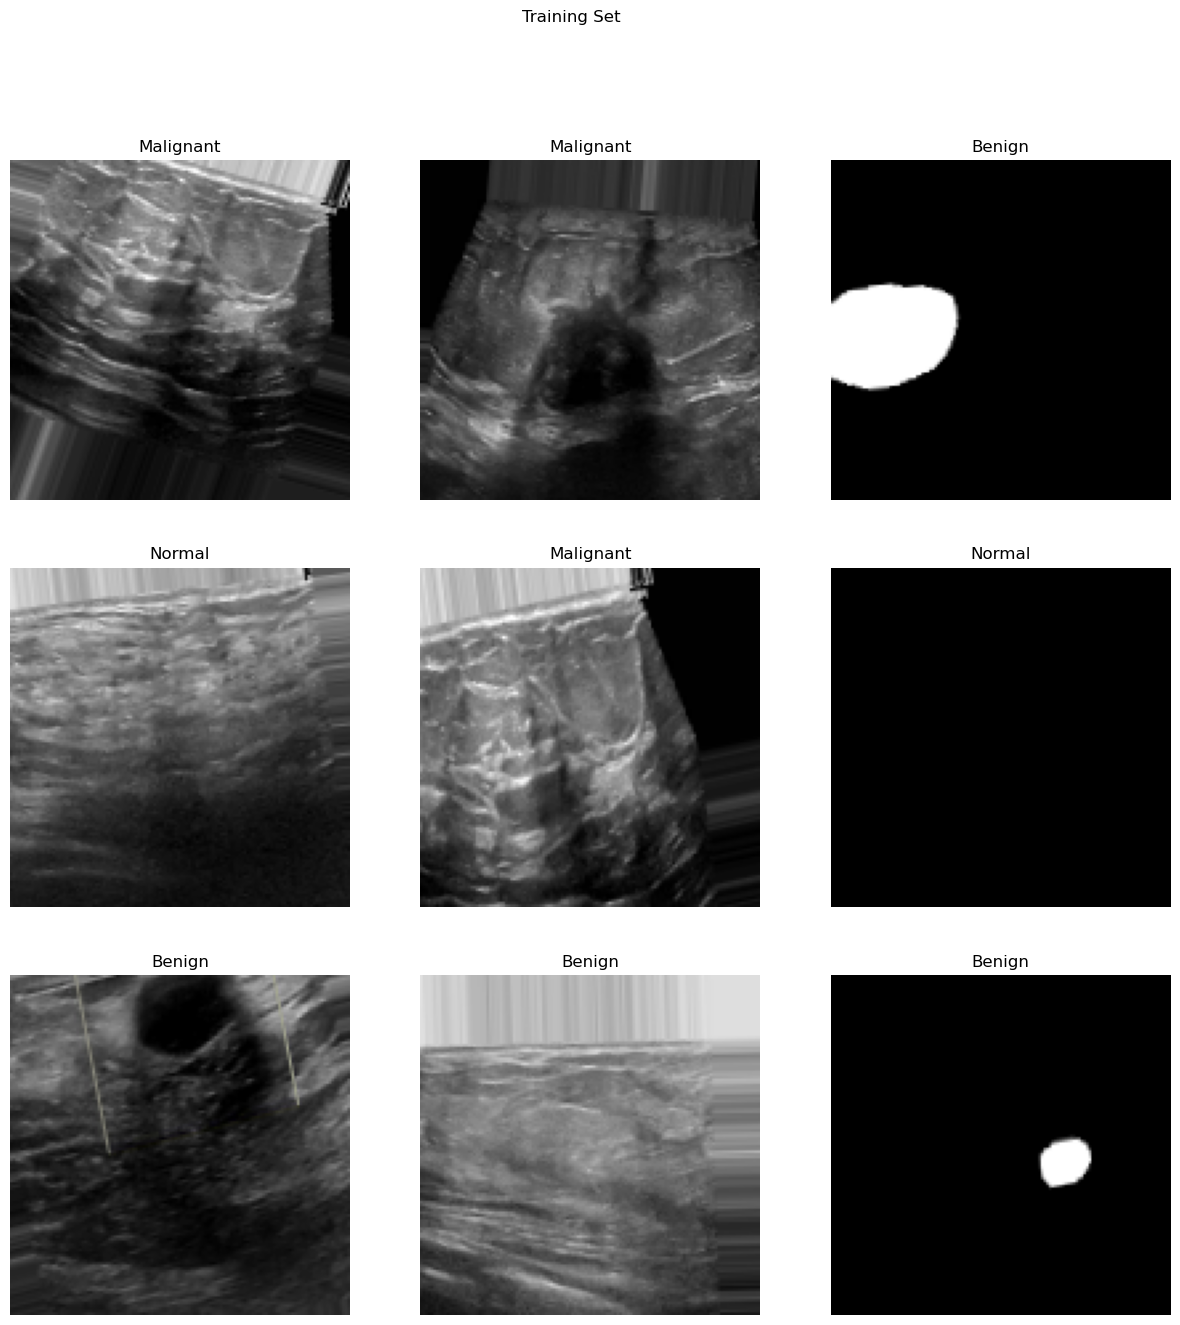

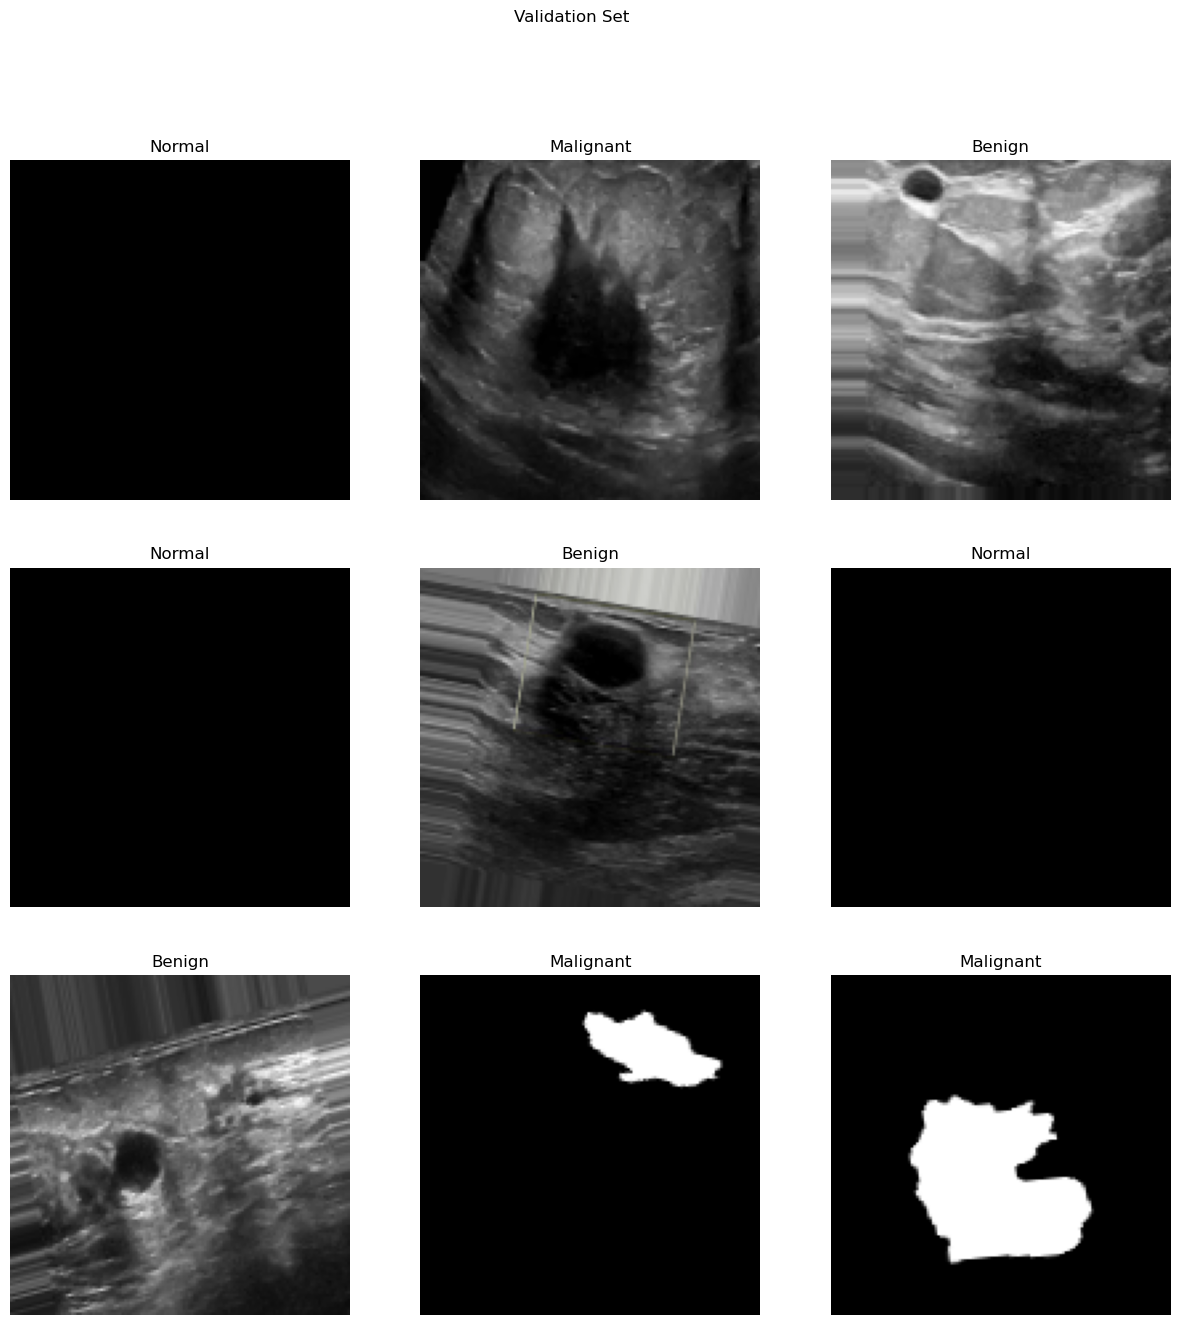

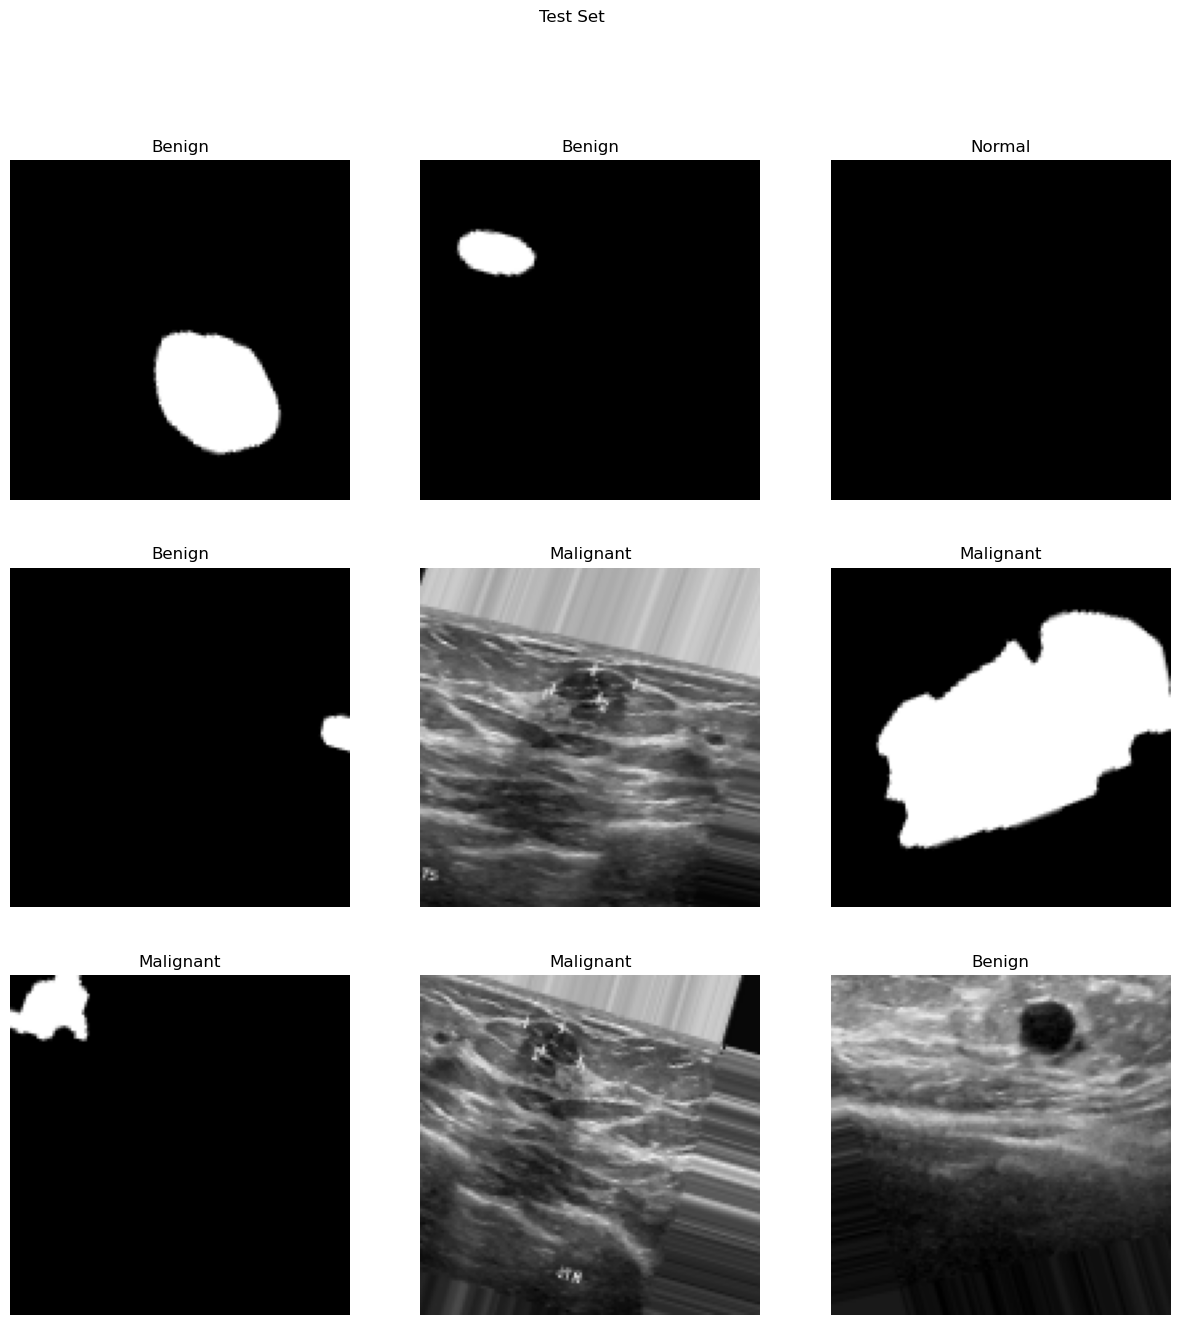

X_train shape: (105, 128, 128, 3)
y_train shape: (105, 3)
X_val shape: (30, 128, 128, 3)
y_val shape: (30, 3)
X_test shape: (15, 128, 128, 3)
y_test shape: (15, 3)


In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator



# Image augmentation generator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Function to load and augment images
def load_and_augment_images(folder_path, num_images):
    images = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img_resized = cv2.resize(img, (128, 128))
                img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
                images.append(img_rgb)
                if len(images) >= num_images:
                    break
    augmented_images = []
    for img in images:
        img = np.expand_dims(img, 0)  # Expand dimensions to match the input shape of ImageDataGenerator
        aug_iter = datagen.flow(img)
        aug_images = [next(aug_iter)[0].astype(np.uint8) for _ in range(3)]  # Generate 3 augmented images per original image
        augmented_images.extend(aug_images)
        if len(augmented_images) >= num_images:
            break
    return augmented_images[:num_images]

# Load and augment images for each category
for category in image_data.keys():
    category_folder = os.path.join(root_folder, category)
    image_data[category] = load_and_augment_images(category_folder, 50)  # Load more images to ensure sufficient data for splits

# Combine all data and create labels
all_images = []
all_labels = []
for category, images in image_data.items():
    all_images.extend(images)
    all_labels.extend([category] * len(images))

all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Split data into train, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(all_images, all_labels, test_size=0.3, stratify=all_labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3333, stratify=y_temp, random_state=42)

# Check the distribution of classes in each split
print("Training set class distribution:", np.unique(y_train, return_counts=True))
print("Validation set class distribution:", np.unique(y_val, return_counts=True))
print("Test set class distribution:", np.unique(y_test, return_counts=True))

# Function to display images
def display_images(images, labels, title):
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    for i, ax in enumerate(axes.flat):
        if i < len(images):
            ax.imshow(images[i])
            ax.set_title(labels[i].capitalize())
            ax.axis('off')
    fig.suptitle(title)
    plt.show()

# Display images from each set
display_images(X_train[:9], y_train[:9], "Training Set")
display_images(X_val[:9], y_val[:9], "Validation Set")
display_images(X_test[:9], y_test[:9], "Test Set")

# Prepare data for model training
# Normalize pixel values to [0, 1]
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

# Convert labels to one-hot encoding
from tensorflow.keras.utils import to_categorical
label_map = {'benign': 0, 'malignant': 1, 'normal': 2}
y_train = to_categorical([label_map[label] for label in y_train], num_classes=3)
y_val = to_categorical([label_map[label] for label in y_val], num_classes=3)
y_test = to_categorical([label_map[label] for label in y_test], num_classes=3)

# Print shapes of the datasets
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


# RESNET50

In [5]:
NUM_CLASSES = 3
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 50

# Load pre-trained ResNet50 model without top layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers in the base model
for layer in resnet_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(resnet_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model = tf.keras.Model(inputs=resnet_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(),
              loss='binary_crossentropy',
              metrics='accuracy')

# Print model summary
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']         

In [6]:
history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val))

Epoch 1/50
4/4 [==============================] - 7s 561ms/step - loss: 0.7248 - accuracy: 0.2667 - val_loss: 0.6924 - val_accuracy: 0.5000
Epoch 2/50
4/4 [==============================] - 0s 40ms/step - loss: 0.6705 - accuracy: 0.4000 - val_loss: 0.6023 - val_accuracy: 0.4333
Epoch 3/50
4/4 [==============================] - 0s 40ms/step - loss: 0.6207 - accuracy: 0.4381 - val_loss: 0.6135 - val_accuracy: 0.5000
Epoch 4/50
4/4 [==============================] - 0s 43ms/step - loss: 0.6126 - accuracy: 0.4857 - val_loss: 0.5811 - val_accuracy: 0.3000
Epoch 5/50
4/4 [==============================] - 0s 41ms/step - loss: 0.5937 - accuracy: 0.4857 - val_loss: 0.5868 - val_accuracy: 0.3000
Epoch 6/50
4/4 [==============================] - 0s 42ms/step - loss: 0.5913 - accuracy: 0.3238 - val_loss: 0.5672 - val_accuracy: 0.3000
Epoch 7/50
4/4 [==============================] - 0s 41ms/step - loss: 0.5775 - accuracy: 0.4476 - val_loss: 0.5529 - val_accuracy: 0.6000
Epoch 8/50
4/4 [==========

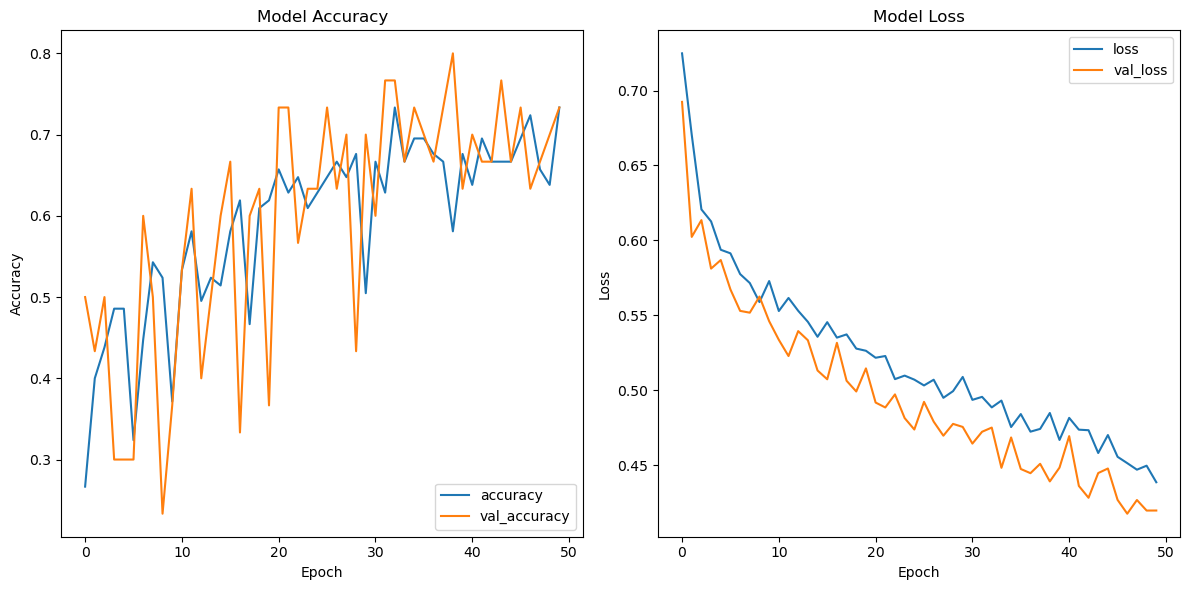

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [19]:
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 1s 598ms/step - loss: 0.6261 - accuracy: 0.5333
Test Loss: 0.6261356472969055
Test Accuracy: 0.5333333611488342


# MobilenetV2

In [12]:
NUM_CLASSES = 3
IMG_SIZE = 128
BATCH_SIZE = 32
EPOCHS = 20

# Load pre-trained MobileNetV2 model without top layers
mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))

# Freeze the layers in the base model
for layer in mobilenet_model.layers:
    layer.trainable = False

# Add custom top layers
x = GlobalAveragePooling2D()(mobilenet_model.output)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

# Create the model
model2 = tf.keras.Model(inputs=mobilenet_model.input, outputs=predictions)


In [13]:
model2.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary
model2.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 64, 64, 32)   864         ['input_3[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 64, 64, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 64, 64, 32)   0           ['bn_Conv1[0][0]']         

In [14]:
history2 = model2.fit(X_train, y_train,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    validation_data=(X_val, y_val),
                   )

Epoch 1/20
4/4 [==============================] - 4s 403ms/step - loss: 2.1654 - accuracy: 0.4000 - val_loss: 0.5240 - val_accuracy: 0.8333
Epoch 2/20
4/4 [==============================] - 0s 25ms/step - loss: 0.9004 - accuracy: 0.7810 - val_loss: 0.6058 - val_accuracy: 0.8667
Epoch 3/20
4/4 [==============================] - 0s 25ms/step - loss: 0.4649 - accuracy: 0.8667 - val_loss: 0.3724 - val_accuracy: 0.8333
Epoch 4/20
4/4 [==============================] - 0s 25ms/step - loss: 0.3255 - accuracy: 0.8762 - val_loss: 0.4095 - val_accuracy: 0.8333
Epoch 5/20
4/4 [==============================] - 0s 25ms/step - loss: 0.1589 - accuracy: 0.9524 - val_loss: 0.2406 - val_accuracy: 0.8667
Epoch 6/20
4/4 [==============================] - 0s 25ms/step - loss: 0.1749 - accuracy: 0.9714 - val_loss: 0.3621 - val_accuracy: 0.8667
Epoch 7/20
4/4 [==============================] - 0s 25ms/step - loss: 0.1595 - accuracy: 0.9524 - val_loss: 0.3175 - val_accuracy: 0.9000
Epoch 8/20
4/4 [==========

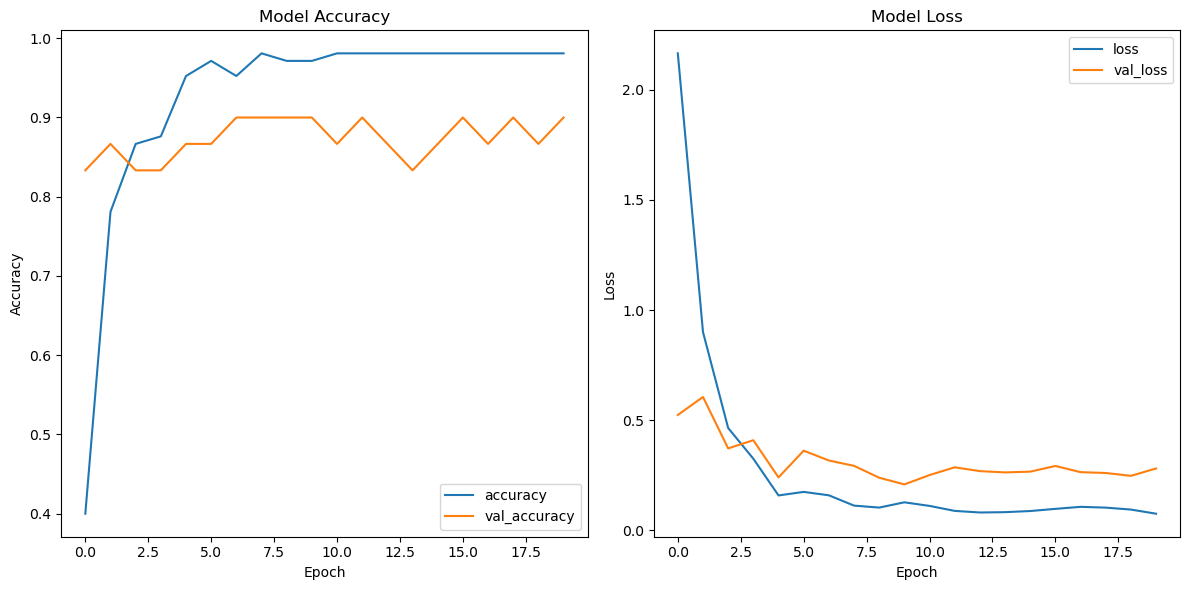

In [17]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='accuracy')
plt.plot(history2.history['val_accuracy'], label='val_accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='loss')
plt.plot(history2.history['val_loss'], label='val_loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

In [18]:
test_loss, test_accuracy = model2.evaluate(X_test, y_test, verbose=1)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

1/1 [==============================] - 0s 406ms/step - loss: 0.3957 - accuracy: 0.8000
Test Loss: 0.3957487642765045
Test Accuracy: 0.800000011920929
